In [1]:
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model

Using TensorFlow backend.
C:\Users\wilson\Anaconda3\envs\tf-wilson\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wilson\Anaconda3\envs\tf-wilson\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wilson\Anaconda3\envs\tf-wilson\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wilson\Anaconda3\envs\t

In [2]:
def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = parse_voc_annotation(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

In [3]:
def create_callbacks(saved_weights_name, model_to_save):
    
    early_stop = EarlyStopping(
        monitor     = 'loss', 
        min_delta   = 0.01, 
        patience    = 5, 
        mode        = 'min', 
        verbose     = 1
    )
    checkpoint = CustomModelCheckpoint(
        model_to_save   = model_to_save,
        filepath        = saved_weights_name,# + '{epoch:02d}.h5', 
        monitor         = 'loss', 
        verbose         = 1, 
        save_best_only  = True, 
        mode            = 'min', 
        period          = 1
    )
    reduce_on_plateau = ReduceLROnPlateau(
        monitor  = 'loss',
        patience = 2,
        verbose  = 1,
        mode     = 'min',
        epsilon  = 0.01,
    )    
    return [early_stop, checkpoint, reduce_on_plateau]

In [4]:
def create_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, batch_size, 
    warmup_batches, 
    ignore_thresh,  
    saved_weights_name, 
    lr,
    grid_scales,
    obj_scale=5,
    noobj_scale=1,
    xywh_scale=1,
    class_scale=1  
):
    train_model, infer_model = create_yolov3_model (               
        nb_class            = nb_class, 
        anchors             = anchors, 
        max_box_per_image   = max_box_per_image, 
        max_grid            = max_grid, 
        batch_size          = batch_size, 
        warmup_batches      = warmup_batches,
        ignore_thresh       = ignore_thresh,
        grid_scales         = grid_scales,
        obj_scale           = obj_scale,
        noobj_scale         = noobj_scale,
        xywh_scale          = xywh_scale,
        class_scale         = class_scale
    )  

    if os.path.exists(saved_weights_name): 
        print("\nLoading pretrained weights.\n")
        train_model.load_weights(saved_weights_name)
    else:
        train_model.load_weights("./backend.h5", by_name=True)         

    optimizer = Adam(lr=lr, clipnorm=0.001)
    train_model.compile(loss=dummy_loss, optimizer=optimizer)             

    return train_model, infer_model

In [6]:
# Parse the annotations 
train_annot_folder = './annotations/'
train_image_folder = './images/'
cache_name = './train_number_0421.pkl'
valid_annot_folder = ''
valid_image_folder = ''
valid_cache_name = ''

labels = ['kangaroo', 'raccoon']
train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
    train_annot_folder,
    train_image_folder,
    cache_name,
    valid_annot_folder,
    valid_image_folder,
    valid_cache_name,
    labels
)
print('\nTraining on: \t' + str(labels) + '\n')

anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]
batch_size = 8
max_input_size = 448
min_input_size = 288

train_generator = BatchGenerator(
    instances           = train_ints, 
    anchors             = anchors,   
    labels              = labels,        
    downsample          = 32, 
    max_box_per_image   = max_box_per_image,
    batch_size          = batch_size,
    min_net_size        = min_input_size,
    max_net_size        = max_input_size,   
    shuffle             = True, 
    jitter              = 0.3, 
    norm                = normalize
)

valid_generator = BatchGenerator(
    instances           = valid_ints, 
    anchors             = anchors,   
    labels              = labels,        
    downsample          = 32, 
    max_box_per_image   = max_box_per_image,
    batch_size          = batch_size,
    min_net_size        = min_input_size,
    max_net_size        = max_input_size,   
    shuffle             = True, 
    jitter              = 0.0, 
    norm                = normalize
)

saved_weights_name = './0421.h5'
warmup_epochs = 3
train_times = 8
ignore_thresh = 0.7
learning_rate = 1e-4
grid_scales = [1,1,1]
obj_scale = 5
if os.path.exists(saved_weights_name): 
    warmup_epochs = 0
warmup_batches = warmup_epochs * (train_times*len(train_generator))

train_model, infer_model = create_model(
    nb_class            = len(labels), 
    anchors             = anchors, 
    max_box_per_image   = max_box_per_image, 
    max_grid            = [max_input_size, max_input_size], 
    batch_size          = batch_size, 
    warmup_batches      = warmup_batches,
    ignore_thresh       = 0.5,
    saved_weights_name  = saved_weights_name,
    lr                  = 1e-4,
    grid_scales         = [1,1,1],

)

callbacks = create_callbacks(saved_weights_name, infer_model)
nb_epochs = 37
print('start training')
train_model.fit_generator(
    generator        = train_generator, 
    steps_per_epoch  = len(train_generator) * train_times, 
    epochs           = nb_epochs + warmup_epochs, 
    verbose          = 1,
    callbacks        = callbacks, 
    workers          = 1,
    max_queue_size   = 8
)

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'kangaroo': 262, 'raccoon': 215}

Given labels: 	['kangaroo', 'raccoon']

Training on: 	['kangaroo', 'raccoon']

Instructions for updating:
Use `tf.cast` instead.



C:\Users\wilson\Anaconda3\envs\tf-wilson\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


start training



Epoch 1/40
288/288 [==============================] - 90s 311ms/step - loss: 198.6534 - yolo_layer_1_loss: 27.6567 - yolo_layer_2_loss: 56.0261 - yolo_layer_3_loss: 114.970714s - loss: 223.5158 - yolo_layer_1_loss: 30.4087 - 

Epoch 00001: loss improved from inf to 198.65344, saving model to ./0421.h5
Epoch 2/40
288/288 [==============================] - 70s 242ms/step - loss: 46.1687 - yolo_layer_1_loss: 10.7129 - yolo_layer_2_loss: 14.0272 - yolo_layer_3_loss: 21.4285

Epoch 00002: loss improved from 198.65344 to 46.16870, saving model to ./0421.h5
Epoch 3/40
288/288 [==============================] - 73s 252ms/step - loss: 37.8734 - yolo_layer_1_loss: 9.2092 - yolo_layer_2_loss: 12.3121 - yolo_layer_3_loss: 16.3521

Epoch 00003: loss improved from 46.16870 to 37.87339, saving model to ./0421.h5
Epoch 4/40
288/288 [==============================] - 71s 247ms/step - loss: 21.6262 - yolo_layer_1_loss: 4.7938 - yolo_layer_2_loss: 7.0862 - yolo_layer_3_loss: 9.7463

Epo

222222222222
C:/Users/wilson/Desktop/keras-yolo3/test_images/00183.jpg
416 416 [55, 69, 75, 234, 133, 240, 136, 129, 142, 363, 203, 290, 228, 184, 285, 359, 341, 260]


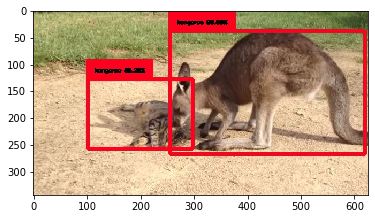

In [14]:
# predict照片
import time
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

input_path   = 'C:/Users/wilson/Desktop/keras-yolo3/test_images/00183.jpg'
output_path  = './test_images/'
makedirs(output_path)

net_h, net_w = 416, 416 
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]

labels = ['kangaroo', 'raccoon']

infer_model = load_model('./0421.h5')

print("222222222222")
image_paths = []
t1=time.time()
if os.path.isdir(input_path): 
    for inp_file in os.listdir(input_path):
        image_paths += [input_path + inp_file]
else:
    image_paths += [input_path]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

for image_path in image_paths:
    image = cv2.imread(image_path)
    print(image_path)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]
    print(net_h, net_w, anchors)

    draw_boxes(image, boxes, labels, obj_thresh) 

    output_img_path = output_path + '_predict' + image_path.split('/')[-1]
    cv2.imwrite(output_img_path, np.uint8(image))
    img = cv2.imread(output_img_path)[:,:,::-1]
    plt.imshow(img)